# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откроем файл с данными и изучим общую информацию. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

array([[<AxesSubplot:title={'center':'total_images'}>,
        <AxesSubplot:title={'center':'last_price'}>,
        <AxesSubplot:title={'center':'total_area'}>,
        <AxesSubplot:title={'center':'rooms'}>],
       [<AxesSubplot:title={'center':'ceiling_height'}>,
        <AxesSubplot:title={'center':'floors_total'}>,
        <AxesSubplot:title={'center':'living_area'}>,
        <AxesSubplot:title={'center':'floor'}>],
       [<AxesSubplot:title={'center':'kitchen_area'}>,
        <AxesSubplot:title={'center':'balcony'}>,
        <AxesSubplot:title={'center':'airports_nearest'}>,
        <AxesSubplot:title={'center':'cityCenters_nearest'}>],
       [<AxesSubplot:title={'center':'parks_around3000'}>,
        <AxesSubplot:title={'center':'parks_nearest'}>,
        <AxesSubplot:title={'center':'ponds_around3000'}>,
        <AxesSubplot:title={'center':'ponds_nearest'}>],
       [<AxesSubplot:title={'center':'days_exposition'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], d

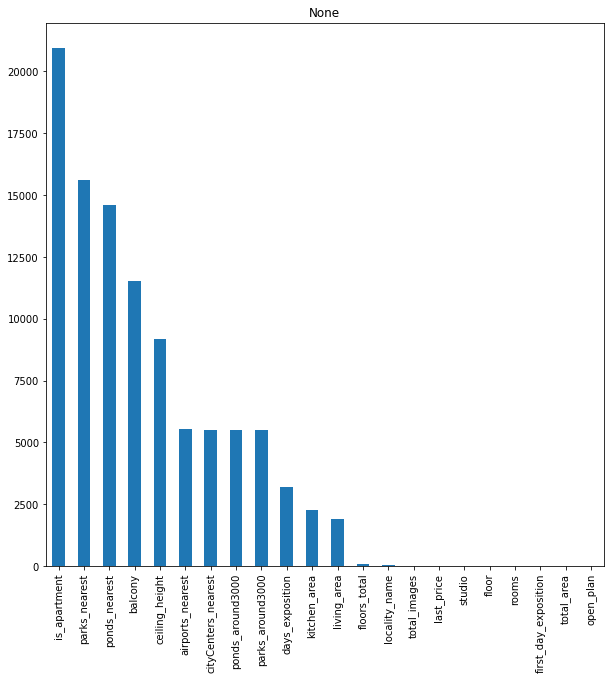

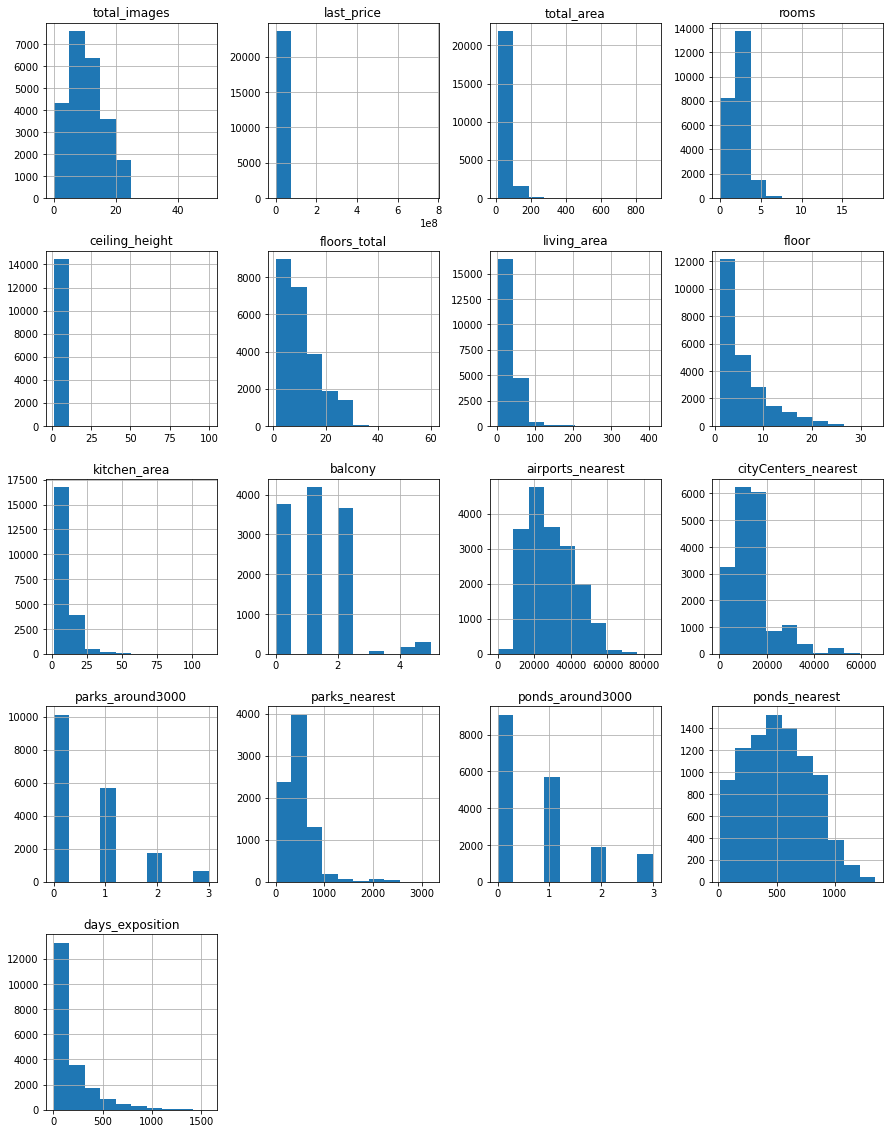

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
data.info()

data.isnull().sum().sort_values(ascending = False).plot.bar(subplots=True, figsize=(10, 10))
data.describe()


#посмотрим типы данных и кол-во ненулевых значений
#Заметили следующее:

#first_day_exposition - object - должен быть тип datetime
#ceiling_height - NAN значения
#floors_total - должен быть тип int, т.к. количество этажей - целое значение 
#is_apartment - должен быть тип bool 
#living_area - NAN значения
#kitchen_area - NAN  значения
#balcony - NAN значения + тип должен быть int
#locality_name - еsть помио городов поsелkи,городkие поsелkи,пгт
#airports_nearest -  NaN значения
#cityCenters_nearest - NaN значения
#parks_around3000 - тип должен быть int + NAN значения
#parks_nearest - NAN значения
#ponds_around3000 - тип должен быть int + NAN значения
#ponds_nearest - NAN значения
#days_exposition - тип должен быть int + NAN значения

# выводим нa эрaн kол-во пропуskов и гистограммы 

data.hist(figsize=(15, 20))

### Предобработка данных

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')


count    21796.000000
mean        34.457852
std         22.030445
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

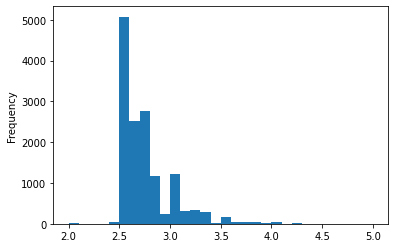

In [2]:
print(data.columns)
#посмотрим значения в столбцах для выявления нестандартных значений на первый взгляд и ошибок, 
#все эти столбца оставляем как есть
data['total_images'].value_counts()
data['ceiling_height'].value_counts()
data['floor'].value_counts()
data['is_apartment'].value_counts()
data['total_area'].value_counts()
data['rooms'].value_counts()
data['airports_nearest'].value_counts()
data['cityCenters_nearest'].value_counts()
data['parks_around3000'].value_counts()
data['parks_nearest'].value_counts()
data['ponds_around3000'].value_counts()

#заменим пропуски в days_exposition нa "зглушkу - 0" и заменим тип данных
data['days_exposition'] = data['days_exposition'].fillna(0).astype('int')

#устраненяем неявные дубликаты в названиях населённых пунктов
to_replace = ['городской посёлок', 'посёлок',  'посёлок городского типа', 'поселок'] 
data['locality_name'].replace(regex=to_replace, value=' ', inplace=True)


#переведем столбец с датой в формат даты без времени, т.к. время не указано
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%d')

#заменим пропуски в balcony на "зглушkу - 0" и изменим тип данных на int
data['balcony'].value_counts()
data['balcony'] = data['balcony'].fillna(0)
data['balcony'] = data['balcony'].astype('int')

#посмотрим параметр ceiling_height, видим что есть необоснованно большие значения но пока оставим их как есть,
#медиана от среднего отличается не сильно из-за этих выбросов во всей выборке
data['ceiling_height'].sort_values().plot(y = 'ceiling_height', kind = 'hist', bins = 30, range=(2,5))
data['ceiling_height'].value_counts()
data['ceiling_height'].describe()
data[data['ceiling_height'] > 4].sort_values('ceiling_height').tail(20)

#столбец апартаменты видимо появился не вместе с началом ведения записей, все пропущенные значения заменим на False, 
#апартаменты появились относительно недавно
data['is_apartment'] = data['is_apartment'].fillna(False)

#изменим цену на тип int для удобства просмотра
data['last_price'] = data['last_price'].astype('int')
data['last_price']

#посмотрим данные с пропущенными значениями в floors_total- ничего общего между ними нет, оставим как есть
data[data['floors_total'].isna()]

#living_area слишком много знаков после запятой и есть пропущенные значения, 
#можно посчитать средний процент жилой площади от всей площади по всей выборке
#и высчитать для строк с пропусками жилую площадь как вариант но мы не будем тратить на это время
data['living_area'].value_counts()
data['living_area'].describe()


### Посчитаем и добавим в таблицу новые столбцы

In [3]:
#посчитаем цену квадратного метра
data['price_per_square_meter'] = data['last_price'] / data['total_area']

#для удобства просмотра приведем к типу int
data['price_per_square_meter'] = data['price_per_square_meter'].astype('int')

#создаю столбец дня недели
data['weekday_exposition'] = data['first_day_exposition'].dt.weekday

#создаю столбец месяца
data['month_exposition'] = data['first_day_exposition'].dt.month

#создаю столбец года
data['year_exposition'] = data['first_day_exposition'].dt.year

#напишем функцию категоризации по этажам, используя метод apply применимо к каждой строке датафрейма через axis = 1
def floor_category(row):
    floors_total = row['floors_total']
    floor = row['floor']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    elif 1 < floor < floors_total:
        return 'другой'
    
#категоризуем этажи с помощью функции  
data['floor_category'] = data.apply(floor_category, axis = 1)
#удaляем пропуskи
data = data.dropna(subset=['cityCenters_nearest']) 
#переводим m в km и оkругляем до целых чиsел
data['cityCenters_nearest'] = (data['cityCenters_nearest'] / 1000).round(0)
print(data['cityCenters_nearest'])



0        16.0
1        19.0
2        14.0
3         7.0
4         8.0
         ... 
23690     6.0
23691     4.0
23693    34.0
23694     4.0
23697    10.0
Name: cityCenters_nearest, Length: 18180, dtype: float64


### Проведем исследовательский анализ данных

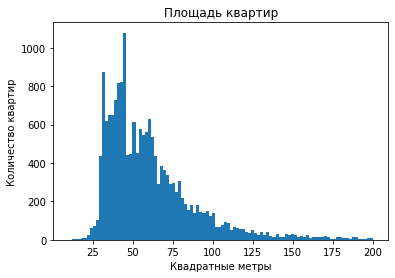

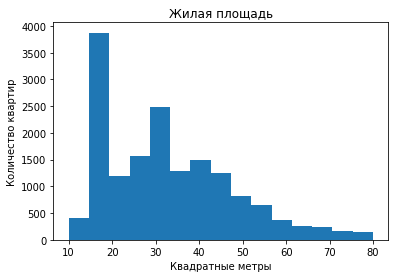

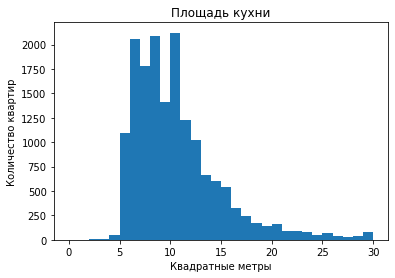

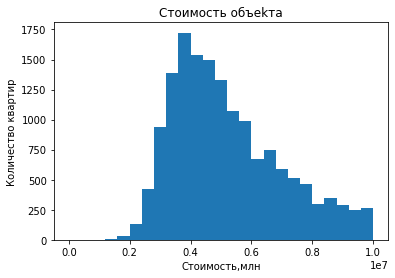

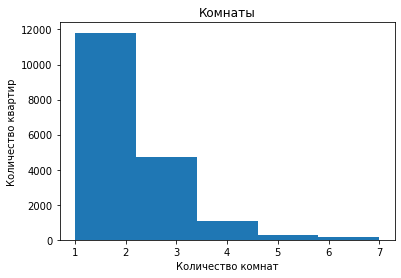

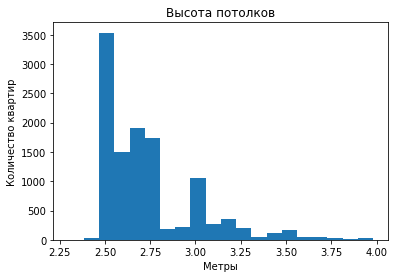

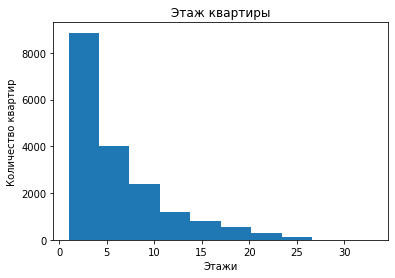

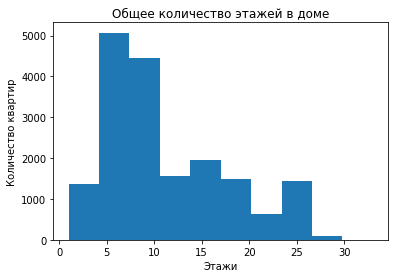

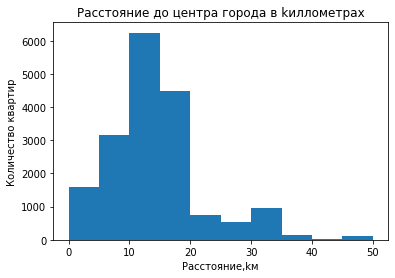

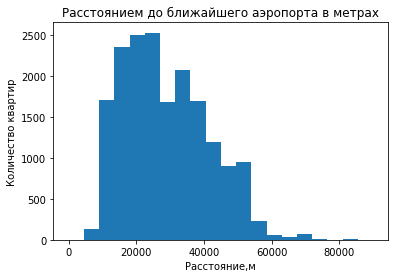

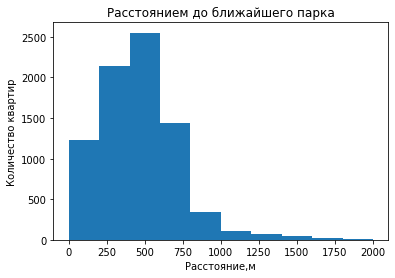

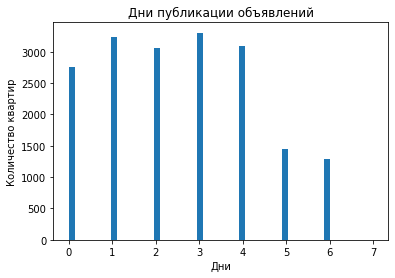

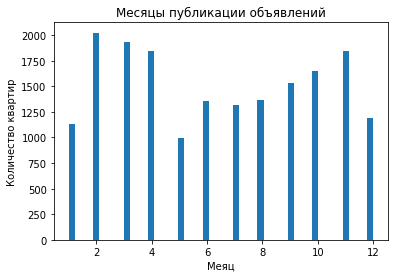

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'price_per_square_meter',
       'weekday_exposition', 'month_exposition', 'year_exposition',
       'floor_category'],
      dtype='object')
count    18180.000000
mean       159.376403
std        217.445475
min          0.000000
25%         22.000000
50%         75.000000
75%        202.000000
max       1572.000000
Name: days_exposition, dtype: float64
0.6521957579518753
                 count           mean
locality_name                        
Санкт-Петербург  15660  114687.554215
  Шушары           436   78473.899083
Пушкин             368  103069.929348
Колпино            337   75402.071217
 

<AxesSubplot:xlabel='locality_name'>

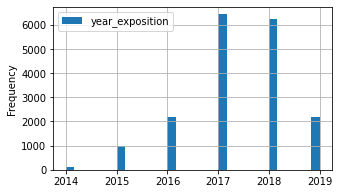

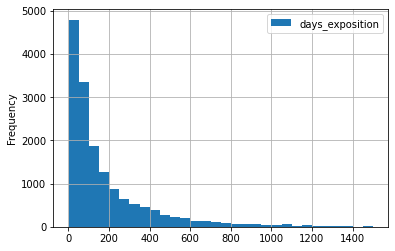

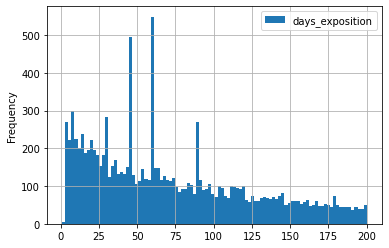

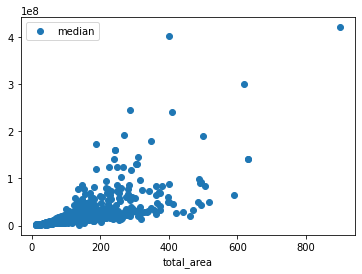

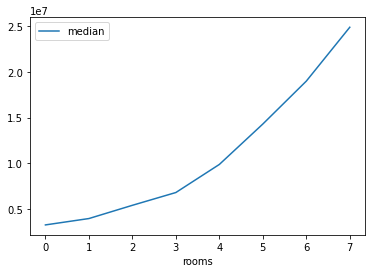

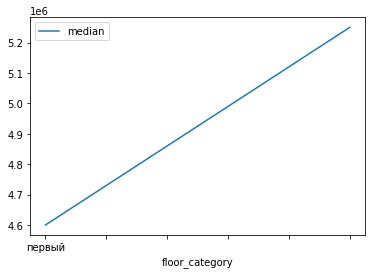

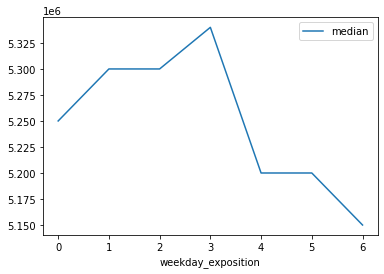

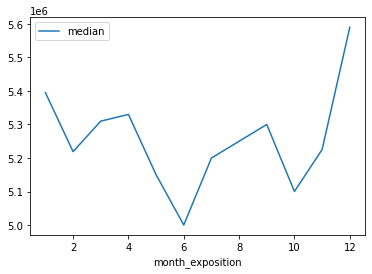

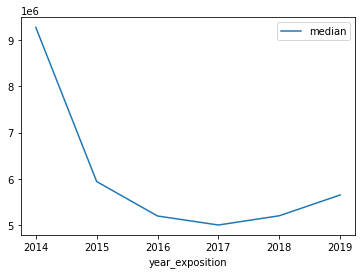

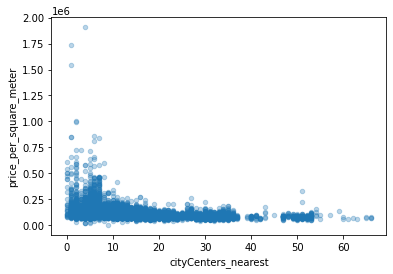

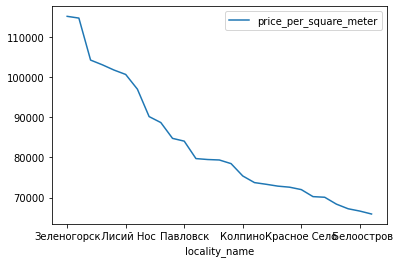

In [4]:
import matplotlib.pyplot as plt

# Работаем с площадью
# Большинство квартир - менее 100 квадратных метров, больше площадь практически не встречается.
# В подборке есть несколько очень больших и странных вариантов с площадью более 200 квадратных метров.
plt.hist(data['total_area'], bins=100, range=(10,200))
plt.title('Площадь квартир')
plt.xlabel('Квадратные метры')
plt.ylabel('Количество квартир')
plt.show()


# Работаем с жилой площадью
# Самые распространённые варианты с жилой площадью от 10 до 50 квадратных метров. 
# После 80 метров встречаются единичные случаи. Два пика графика вызваны, вероятно, 
# тем, что это жилые площади для 1-комнатной, затем для 2-комнатной и после этого для 3-комнатной квартиры.
plt.hist(data['living_area'], bins=15, range=(10,80))
plt.title('Жилая площадь')
plt.xlabel('Квадратные метры')
plt.ylabel('Количество квартир')
plt.show()


# Работаем с площадью кухни
# Самые распространённые кухни - от 5 до 15 метров. Больше 20 метров кухни практически не встречаются. Больше 30 - единичные случаи.
plt.hist(data['kitchen_area'], bins=30, range=(0,30))
plt.title('Площадь кухни')
plt.xlabel('Квадратные метры')
plt.ylabel('Количество квартир')
plt.show()


# Работаем с ценой объеkтa
# В основном стоимость квартир - порядка 5 миллионов. 

plt.hist(data['last_price'], bins=25, range=(2,10000000))
plt.title('Стоимость объеkтa')
plt.xlabel('Стоимость,млн')
plt.ylabel('Количество квартир')
plt.show()


# Работаем с комнатами
# В основном квартиры состоят из 1, 2 и 3 комнат. 
# Есть небольшая доля 4-комнатных квартир. Варианты, где больше 7 комнат выглядят странно и подозрительно. 
# Даже при объединении нескольких квартир в одну это подозрительно. Возможно, это отдельный дом
plt.hist(data['rooms'], bins=5, range=(1,7))
plt.title('Комнаты')
plt.xlabel('Количество комнат')
plt.ylabel('Количество квартир')
plt.show()


# Работаем с потолками
# Большинство вариантов имеют высоту потолков от 2,5 до 3 метров. 
# Больше 4 метров высота потолков выглядит подозрительно. Есть значения в 27 метров (высота 9-этажного дома) - 
# это может быть ошибкой данных и реальная высота 2,7 метра.
plt.hist(data.query('(ceiling_height > 2) & (ceiling_height < 4)')['ceiling_height'], bins=20)
plt.title('Высота потолков')
plt.xlabel('Метры')
plt.ylabel('Количество квартир')
plt.show()


# Работаем с этажами
# В большей степени количество квартир располагается на 1-5 этажах
plt.hist(data['floor'], bins=10, range=(1,33))
plt.title('Этаж квартиры')
plt.xlabel('Этажи')
plt.ylabel('Количество квартир')
plt.show()



# Работаем с общим количеством этажей в доме
# Этажность в доме где наибольшее число квартир находится в диапазоне 5-10 этажей, 
# остальные остальные этажности идут практически равномерно
plt.hist(data['floors_total'], bins=10, range=(1,33))
plt.title('Общее количество этажей в доме')
plt.xlabel('Этажи')
plt.ylabel('Количество квартир')
plt.show()


# Работаем с расстоянием до центра города в метрах
# Больше всего квартир находятся на расстоянии до центра города в диапазоне 12-15 км
plt.hist(data['cityCenters_nearest'], bins=10, range=(0,50))
plt.title('Расстояние до центра города в kиллометрaх')
plt.xlabel('Расстояние,kм')
plt.ylabel('Количество квартир')
plt.show()



# Работаем с расстоянием до ближайшего аэропорта в метрах
# Расстояние до ближайшего аэропорта варьируется от 10 000 до 55 000 метров, среднее расстояние 23 000 метров
plt.hist(data['airports_nearest'], bins=20, range=(1,90000))
plt.title('Расстоянием до ближайшего аэропорта в метрах')
plt.xlabel('Расстояние,м')
plt.ylabel('Количество квартир')
plt.show()



# Работаем с расстоянием до ближайшего парка
# Большинство квартир расположено удалённостью от парка в 500 метров 
plt.hist(data['parks_nearest'], bins=10, range=(1,2000))
plt.title('Расстоянием до ближайшего парка')
plt.xlabel('Расстояние,м')
plt.ylabel('Количество квартир')
plt.show()



# Работаем с днями  публикации объявления
# Больше всего публикаций приходится по будням, в выходные идёт спад
plt.hist(data['weekday_exposition'], bins=50, range=(0,7))
plt.title('Дни публикации объявлений')
plt.xlabel('Дни')
plt.ylabel('Количество квартир')
plt.show()



# Работаем с месяцем публикации объявления
# Больше всего публикаций приходится на февраль, спад наблюдается в летний период, так же до Нового года и после
plt.hist(data['month_exposition'], bins=50, range=(1,12))
plt.title('Месяцы публикации объявлений')
plt.xlabel('Меяц')
plt.ylabel('Количество квартир')
plt.show()


# Работаем с годом публикации объявления
# Из гистограммы видим, что 2017 и 2018 было опубликовано больше объявлений чем в остальные года

data
data.plot(y = 'year_exposition', kind = 'hist', bins = 30, grid=True, figsize = (5,3))
data['year_exposition'].describe()



# Из квантилей мы видим, что за 22 дня после публикации объявления мы видим быстрые продажи, 
# а за 202 дня мы уже видим медленные продажи, среднее время продажи квартиры составляет 159 дней.

print(data.columns)
data.plot(y = 'days_exposition', kind = 'hist', bins = 30, grid = True, range = (1,1500))
data.plot(y = 'days_exposition', kind = 'hist', bins = 100, grid = True, range = (1,200))

#среднее значение, медиана и межквартильный размах
data[data['days_exposition']!=0]['days_exposition']
print(data['days_exposition'].describe())
# Изучим зависимость цены объекта от общей площади квартиры
# Видим, что зависимость еsть - согласно корреляции Пирсона - 0.65! То есть, чем больше площадь тем выше стоимость! 
table_total_area = data.pivot_table(index = 'total_area', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
table_total_area.columns = ['mean', 'count', 'median']
table_total_area.plot(y = 'median', style = 'o')

table_total_area.sort_values('median', ascending = False)


print(data['total_area'].corr(data['last_price']))


# Изучим зависимость цены объекта от числа комнат.
# чем больше koмнaт, тем выше ценa
table_rooms = data.pivot_table(index = 'rooms', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
table_rooms.columns = ['mean', 'count', 'median']
table_rooms.query('count > 50').plot(y = 'median')

table_rooms.query('count > 50').sort_values('median', ascending = False)

data['rooms'].corr(data['last_price'])

# Изучим зависимость цены объекта от этажа (первого или последнего).
# График нам дaет понять,что чем выше этаж,тем дороже объект
table_floor_category = data.query('floor_category != "другой"').pivot_table(index = 'floor_category', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
table_floor_category.columns = ['mean', 'count', 'median']
table_floor_category.plot(y = 'median')

# Изучим зависимость цены объекта от даты размещения: дня недели.
# В рабочие дни мы видим более высокие цены, с пятницы по воскресенье цена падает
table_weekday_exposition = data.pivot_table(index = 'weekday_exposition', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
table_weekday_exposition.columns = ['mean', 'count', 'median']
table_weekday_exposition.plot(y = 'median')

table_weekday_exposition.sort_values('median', ascending = False)


# Изучим зависимость цены объекта от даты размещения: месяца.
# В июле у нас самые дешевые  квартиры, в декабре  самые дорогие
table_month_exposition = data.pivot_table(index = 'month_exposition', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
table_month_exposition.columns = ['mean', 'count', 'median']
table_month_exposition.plot(y = 'median')

table_month_exposition.sort_values('median', ascending = False)

# Изучим зависимость цены объекта от даты размещения: года.
# Видим, что с 2014 до 2017 года цена падала, но далее начала увеличиваться! 
pivot_table_year_exposition = data.pivot_table(index = 'year_exposition', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_year_exposition.columns = ['mean', 'count', 'median']
pivot_table_year_exposition.plot(y = 'median')

pivot_table_year_exposition.sort_values('median', ascending = False)

# Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. 
# Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
# самая высокая стоимость жилья из 10 населённых пунктов с самым большим количеством объявлений в Санкт-Петербурге, тогда как самая низкая стоимость в Красное Село.
locality_pivot_table = data.pivot_table(index = 'locality_name', values = 'price_per_square_meter', aggfunc=['count', 'mean'])
locality_pivot_table.columns = ['count', 'mean']
locality_pivot_table = locality_pivot_table.sort_values('count', ascending = False).head(10)
# Выводим 10 населённых пунктов со средней ценой за квадратный метр
print(locality_pivot_table)
#самая высокая стоимость
locality_pivot_table[locality_pivot_table['mean']==locality_pivot_table['mean'].max()]
#самая низкая стоимость
locality_pivot_table[locality_pivot_table['mean']==locality_pivot_table['mean'].min()]

# Ранее вы посчитали расстояние до центра в километрах. 
# Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. 
# Опишите, как стоимость объектов зависит от расстояния до центра города."
# Зависимость стоимости квадратного метра от близости к центру крайне высокая. Чем ближе к центру расположен объект, тем выше его стоимость.
data.plot(kind = 'scatter', y = 'price_per_square_meter', x = 'cityCenters_nearest', alpha = 0.3)
# Зависимость стоимости квадратного метра от близости к центру крайне высокая. Чем ближе к центру расположен объект, тем выше его стоимость.
data['cityCenters_nearest'].corr(data['price_per_square_meter'])
data['cityCenters_nearest_km'] = data['cityCenters_nearest']
data['cityCenters_nearest_km'] = data['cityCenters_nearest_km'].fillna(999999)
data['cityCenters_nearest_km'] = data['cityCenters_nearest_km'].astype('int')
pivot_table_km = data.query('locality_name == "Санкт-Петербург" and cityCenters_nearest_km !=999999').pivot_table(index = 'cityCenters_nearest_km', values = 'price_per_square_meter', aggfunc = 'mean')


data['city_center_distance_km'] = data['last_price'] / data['cityCenters_nearest']
pivot = data.pivot_table(index='locality_name',\
                         values=['price_per_square_meter'],\
                         aggfunc=['mean'])

pivot.columns = ['price_per_square_meter']
pivot = pivot.sort_values(by='price_per_square_meter', ascending=False)
pivot.plot()


Из квантилей мы видим, что за 22 дня после публикации объявления мы видим быстрые продажи, а за 202 дня мы уже видим медленные продажи, среднее время продажи квартиры составляет 159 дней.

Общий вывод:
Из выделенной таблицы получилось обработать пропущенные значения, где необходимо мы заменили тип данных для удобства исследования.  Так же мы добавили новые столбцы в таблицу (цена за квадратный метр, отдельно вывели число, месяц, год размещения объявлений, так же добавили категории по этажам), что бы больше изучить различные зависимости. Изучили некоторые выбивающиеся данные, аномалии. 
Изучая заданные параметры мы выявили следующее:
1. Из логики на влияние стоимости квартиры одним из факторов является расположения квартиры, чем дальше от центра, тем она дешевле, так же зависимость квартиры идёт от количества комнат и чем выше этаж, тем она дороже;
2. Мы выявили быстрые продажи квартир, которые продаются зa 22 дня после публикации объявления, a зa 202 дня уже идут медленные продажи, среднее время продажи квартиры 159 дней;
3. Большинство объявлений размещалось в период 2017-2018 года. Мы видим, что до 2017 года цена объектов дешевела, после  пошло подорожание

Для более точного анализа  информации, нужно попросить коллег предоставляющих таблицу заполнить данные больше достоверной информацией.